# QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing

This notebook demonstrates the pipeline of solving the Bin Packing problem using QAL-BP.

Consider that when using Quantum Annealing results may stongly vary from one run to another, influencing also the benchmark analysis.

**IMPORTANT: before running this notebook create a config.py file with the variable dimod.token="your_token" in the same folder of the notebook**

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !git clone https://github.com/Lorenz92/QAL-BP.git

Cloning into 'QAL-BP'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 177 (delta 38), reused 161 (delta 22), pack-reused 0
Receiving objects: 100% (177/177), 1.50 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
%cd QAL-BP/
!ls

/content/QAL-BP
config.py  gurobi_df_40_instances.csv  __pycache__  QAL_BP.ipynb  README.md  results  utils.py


## Install and Import Dependencies

In [3]:
# If this notebook is running on Windows OS, change apt with tlmgr
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core fonts-dejavu-extra
  fonts-droid-fallback fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go fonts-junicode fonts-lato
  fonts-linuxlibertine fonts-lmodern fonts-lobster fonts-lobstertwo fonts-noto-color-emoji
  fonts-noto-core fonts-noto-mono fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted
  fonts-sil-charis fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fo

In [4]:
!pip install gurobipy pyqubo dimod dwave-system SciencePlots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [5]:
# ! pip install dwave-inspector
# ! pip install dwave-inspectorapp --extra-index=https://pypi.dwavesys.com/simple

In [163]:
import pandas as pd
from utils import *
import shutil
import gc
from google.colab import files
import time
from google.colab import drive
import os

drive.mount('/content/drive')

json_path = './solutions/'
num_reads = 1000

%matplotlib inline

%load_ext autoreload
%autoreload 2

# The following parameter decide wether to read past results from file or from newly computed experiments
results_from_file = True

# The following parameter allows to run also the exact solver (this might take a lot of time)
run_exact_solver = False

# The following parameter controls wether to include also the Pseudo Polynomial model in the experiments
solve_PseudoPoly = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Bin Packing Problem

The bin packing problem (BPP) is a classic optimization task that involves packing objects of different sizes into containers, or bins, with a limited capacity.
The goal is to minimize the number of bins needed to pack all the objects.
A mathematical formulation of the bin packing problem can be expressed as follows: given a set of $n$ items of given integer size (or weight) $w_j \ (j = 1, \ldots , n)$ the goal is to pack them
 into the minimum number of identical bins of integer capacity $C$.

Let $m$ be any upper bound on the solution value and let introduce $y_i, x_{ij}$ two sets of binary variables such that:
$y_i (i = 1, \ldots, m)$ takes the value $1$ if and only if bin $i$ is used in the solution
and $x_{ij} (i = 1, \ldots, m; j = 1, \ldots, n)$ takes the value $1$ if and only if item $j$ is packed into bin $i$.
A commonly adopted Integer Linear Programming (ILP) problem formulation is given by *S. Martello and P. Toth, in “Knapsack Problems: Algorithms and Computer Implementation”* and is the following:

\begin{align}
  \underset{x, y}{\operatorname{argmin}} \ & \sum_{i=1}^m y_i \\
  \text{s.t. }
  & \sum_{i=1}^m x_{ij} = 1 & \forall j = 1, \dots, n \\
  & \sum_{j=1}^n w_j x_{ij} \leq C y_i & \forall i = 1, \dots, m \\
  & x_{ij} \in \{0, 1\} & \forall i = 1, \dots, m, \ \forall j = 1, \dots, n  \\
  & y_{i} \in \{0, 1\} & \forall i = 1, \dots, m
\end{align}


## Bin Packing Problem instances generation

In the following experiments we consider a set of 40 instances with number of items ranging from 3 to 10 and a fixed bin capacity of 10. The different instances are randomly generated using 5 different seeds.

In [7]:
# Instances used for QA and SA
seeds = [23, 42, 123, 90, 510]

instances = {
    'bpp_3_10': {
        'num_items' : 3,
        'bin_capacity' : 10,
    },
    'bpp_4_10': {
        'num_items' : 4,
        'bin_capacity' : 10,
    },
    'bpp_5_10': {
        'num_items' : 5,
        'bin_capacity' : 10,
    },
    'bpp_6_10': {
        'num_items' : 6,
        'bin_capacity' : 10,
    },
    'bpp_7_10': {
        'num_items' : 7,
        'bin_capacity' : 10,
    },
    'bpp_8_10': {
        'num_items' : 8,
        'bin_capacity' : 10,
    },
    'bpp_9_10': {
        'num_items' : 9,
        'bin_capacity' : 10,
    },
    'bpp_10_10': {
        'num_items' : 10,
        'bin_capacity' : 10,
    }
}

The following cell is used to generates the parameters $A$ and $B$ of the Pseudo Polynomial model.

In [8]:
As = [.1,.3,.5,1,3,5,10,25,50,100,1000]
Bs = [.01,.05,.1,.5,1,2,5,10]

PP_pens=[]
for a in As:
  for b in Bs:
    pen = {}
    pen['A'] = a
    pen['B'] = b
    PP_pens.append(pen)

print(f'Number of parameters values combination: {len(PP_pens)}')

Number of parameters values combination: 88


Generation of the instances dataframe.

In [9]:
df_seeds = pd.DataFrame()

for seed in seeds:
  df_seed = instance_generator(instances, seed)
  df_seeds = pd.concat([df_seeds, df_seed], axis = 0, ignore_index=True)

df = df_seeds.copy()
df.head()

,instance_name,seed,c,w,n,wmin,wmax,lb
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5


# ILP Formulation of BPP solved via Branch-and-Bound by Gurobi

In this section, we solve the ILP formulation given above via the Gurobi optimizer, as a representative for state-of-the-art solution that relies on the branch-and-bound technique to efficiently find the optimal solution.

In [ ]:
gurobi_df = gurobi_solve(df, num_reads)
gurobi_df.to_csv('./gurobi_df_40_instances.csv',float_format='%.6f')

df_total = pd.concat([df, gurobi_df], axis = 1)
display(df_total)

Restricted license - for non-production use only - expires 2024-10-28


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,gurobi_runtime,bin_filling
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",518.051,"{2: 10, 0: 8}"
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",616.281,"{1: 7, 3: 9, 2: 7}"
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",1168.964,"{0: 8, 4: 7, 2: 7, 1: 9}"
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",2000.353,"{2: 6, 4: 10, 1: 9, 0: 8}"
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",794.839,"{0: 8, 2: 6, 6: 8, 4: 6, 3: 8, 5: 6, 1: 6}"
5,bpp_8_10,23,10,"[4, 5, 6, 4, 5, 4, 6, 4]",8,4,6,4,4.0,"[0, 1, 0, 2, 1, 2, 6, 6]",2664.940,"{0: 10, 1: 10, 2: 8, 6: 10}"
6,bpp_9_10,23,10,"[7, 5, 8, 4, 7, 4, 8, 5, 4]",9,4,8,6,7.0,"[2, 7, 6, 1, 5, 1, 0, 8, 8]",1534.176,"{2: 7, 7: 5, 6: 8, 1: 8, 5: 7, 0: 8, 8: 9}"
7,bpp_10_10,23,10,"[5, 7, 5, 7, 9, 9, 4, 9, 6, 4]",10,4,9,7,8.0,"[5, 0, 8, 7, 6, 9, 8, 2, 4, 4]",2979.454,"{5: 5, 0: 7, 8: 9, 7: 7, 6: 9, 9: 9, 2: 9, 4: 10}"
8,bpp_3_10,42,10,"[4, 8, 7]",3,4,8,2,3.0,"[2, 0, 1]",414.782,"{2: 4, 0: 8, 1: 7}"
9,bpp_4_10,42,10,"[6, 6, 9, 4]",4,4,9,3,3.0,"[2, 0, 1, 0]",487.747,"{2: 6, 0: 10, 1: 9}"


# Pseudo Polynomial Formulation

The first QUBO formulation of the Bin Packing Problem appeared in *Mapping NP-hard and NP-complete optimisation problems to
Quadratic Unconstrained Binary Optimisation problems, by Bas Lodewijks* in 2019. In this publication, the author a QUBO formulation for the bin acking problem, such as the following:

given the variables $x_{ij}, i \in \{1, .., N\}, j \in \{1, .., K\}$, where $x_{ij} = 1$ if weight $j$ is placed in bin $i$, variables $y_i, i \in \{1, .., N\}$, where $y_i = 1$ if bin $i$ is not empty,
and variables $z_{ik}, i \in \{1, .., N\}, k \in \{1, .., C\}$, where $z_{ik} = 1$ if bin $i$ has been filled up to level $k$, that is, when the sum of the weights of the objects in bin $i$ equals exactly $k$.
The Hamiltonian can be written as:
\begin{align}
    H_A = & A\sum_{i=1}^{N} \left( x_i - \sum_{k=1}^C z_{ik} \right)^2 \\
    + & A\sum_{j=1}^{K} \left( 1 - \sum_{i=1}^N x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( \sum_{k=1}^{C}kz_{ik} - \sum_{j=1}^K w_j x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( 1 - x_i \right) \sum_{j=1}^K x_{ij} \\
    H_B = & B\sum_{i=1}^N x_{i}
\end{align}

## Pseudo Polynomial model solved by Simulated Annealing

In the next cell we solve the QUBO formulation given by Lodewijks using SA.

In [ ]:
if solve_PseudoPoly:
  models = ['PP']
  solvers = ['SA']

  pp_penalties = None
  al_penalties= None
  QUBOs_df = pd.DataFrame()
  PP_test_pens = copy.deepcopy(PP_pens)


  for i in tqdm(range(len(PP_test_pens))):
    pp_penalties = PP_test_pens[i]
    QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
    QUBOs_df = pd.concat([QUBOs_df, QUBO_df], axis = 0)

  QUBOs_df.head()

  QUBOs_df.to_csv('./final_PP_grid.csv',float_format='%.6f')


# Aumented Lagrangian QUBO Formulation

In this work, we presented QAL-BP (*Quantum Augmented Lagrangian method for Bin Packing*), a novel QUBO formulation for the BPP based on the Augmented Lagrangian method.

The Quantum Augmented Lagrangian method for Bin Packing (QAL-BP) embeds the constraints using the augmented Lagrangian method as follows:
\begin{align}
    \text{argmin}_{x, y} \ & \delta\sum_{i=1}^m y_i \\
    & + \sum_{i=1}^{m} \lambda_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right) \\
    & + \sum_{i=1}^{m} \rho_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right)^2 \\
    & + \theta \sum_{j=1}^n \left(\sum_{i=1}^m x_{ij}-1\right)^2 \\
    & +  \gamma \sum_{i=1}^m \left(1 - y_i \right)\sum_{j=1}^n x_{ij} \\
    \text{s.t. }
    x_{ij}& \in \{0, 1\} \qquad \forall i = 1 \dots, m, \forall j = 1 \dots, n \nonumber \\ \nonumber
    y_{i} & \in \{0, 1\} \qquad \forall i = 1 \dots, m \\
    \delta, &\lambda, \rho, \theta, \gamma \ge 0 \nonumber
\end{align}

QUBO penalties are estimated according to **QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing Problem** by *Lorenzo Cellini, Antonio Macaluso, and Michele Lombardi*.

In the next two cells the QAL-BP is solved respectively by *Simulated Annealing (SA)* and *Quantum Annealing (QA)*.

### QAL-BP solved by Simulated Annealing

In [ ]:
models = ['AL']
solvers = ['SA']

pp_penalties = None
al_penalties = None

df_final_SA = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
df_final_SA = pd.concat([df_final_SA, QUBO_df], axis = 1)

df_final_SA.to_csv(f'./SA_nr{num_reads}.csv',float_format='%.6f')
df_final_SA.head()

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_SA_real_weights_sum,AL_SA_placed_weights_sum,AL_SA_used_items,AL_SA_feasible,AL_SA_reason,AL_SA_penalties_dict_delta,AL_SA_penalties_dict_theta,AL_SA_penalties_dict_lmbd,AL_SA_penalties_dict_rho,AL_SA_penalties_dict_gamma
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,18,18,"[1, 0, 2]",True,[],0.15,2,0.1389,0.0278,1
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,23,23,"[0, 3, 1, 2]",True,[],0.15,2,0.1389,0.0278,1
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,31,31,"[3, 0, 1, 2, 4]",True,[],0.15,2,0.1389,0.0278,1
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,33,33,"[0, 2, 4, 5, 1, 3]",True,[],0.15,2,0.1389,0.0278,1
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,48,48,"[1, 2, 4, 5, 0, 3, 6]",True,[],0.15,2,0.0758,0.0152,1


### QAL-BP solved by Quantum Annealing

In [ ]:
# models = ['AL']
# solvers = ['QA']

# pp_penalties = None
# al_penalties = None

# df_final_QA = df_total.copy()
# QUBO_df = solve_QUBOs(df.loc[:0], models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
# df_final_QA = pd.concat([df_final_QA, QUBO_df], axis = 1)

# df_final_QA.to_csv(f'./QA_nr{num_reads}.csv',float_format='%.6f')
# df_final_QA.head()

In [ ]:
try:
  shutil.rmtree('solutions')
except:
  print('There is no solutions folder')

There is no solutions folder


In [ ]:
models = ['AL']
solvers = ['QA']

thresholds ={
'bpp_3_10':1,
'bpp_4_10':1,
'bpp_5_10':1,
'bpp_6_10':1,
'bpp_7_10':.8,
'bpp_8_10':.8,
'bpp_9_10':.4,
'bpp_10_10':0,
}

pp_penalties = None
al_penalties = None
df_final_QA = df_total.copy()

instance_class = df_total['instance_name'].unique()

for i in instance_class:
  print(i)
  found = False
  df_experiment = df_total[df_total['instance_name'] == i].copy()

  j = 0
  while not found:
      print(f'Iteration: {j}')
      QUBO_df = solve_QUBOs(df[df['instance_name'] == i], models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
      df_QA = pd.concat([df_experiment.reset_index(), QUBO_df], axis = 1)

      df_feasible_density_QA = df_QA.groupby('instance_name', sort=False)['AL_QA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
      print(df_feasible_density_QA)
      if df_feasible_density_QA.loc[i] >= thresholds[i]:
          found = True
          df_QA.to_csv(f'./solutions/QA_nr{num_reads}_{i}.csv',float_format='%.6f')
          df_QA.to_csv(f'./QA_nr{num_reads}_{i}.csv',float_format='%.6f')
          !zip -r solutions.zip solutions/
          os.rename('solutions.zip', f'{i}_solutions.zip')
          shutil.move(f'{i}_solutions.zip', "../drive/MyDrive/results_for_maca")
      else:
          j+=1
          gc.collect()
      shutil.rmtree('solutions')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bpp_3_10
Iteration: 0
Set penalty as: Default for AL and Default for PP
instance_name
bpp_3_10    1.0
Name: AL_QA_feasible, dtype: float64
  adding: solutions/ (stored 0%)
  adding: solutions/QA_nr1000_bpp_3_10.csv (deflated 68%)
  adding: solutions/bpp_3_10_23_1699723705.json (deflated 72%)
  adding: solutions/bpp_3_10_123_1699723711.json (deflated 74%)
  adding: solutions/bpp_3_10_510_1699723717.json (deflated 71%)
  adding: solutions/bpp_3_10_42_1699723708.json (deflated 71%)
  adding: solutions/bpp_3_10_90_1699723714.json (deflated 72%)
bpp_4_10
Iteration: 0
Set penalty as: Default for AL and Default for PP
instance_name
bpp_4_10    1.0
Name: AL_QA_feasible, dtype: float64
  adding: solutions/ (stored 0%)
  adding: solutions/bpp_4_10_123_1699723731.json (deflated 78%)
  adding: solutions/bpp_4_10_510_1699723739.json (deflated 77%)
  adding: solutions/QA_n

In [ ]:
# models = ['AL']
# solvers = ['QA']

# pp_penalties = None
# al_penalties = None

# df_final_QA = df_total.copy()
# QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
# df_final_QA = pd.concat([df_final_QA, QUBO_df], axis = 1)

# df_final_QA.to_csv(f'./QA_nr{num_reads}.csv',float_format='%.6f')
# df_final_QA.head()

### QAL-BP solved by enumeration (exact method)

**NOTE: be aware that it may take a lot of time and RAM resources to complete**

Indeed we selected the only two smallest instance classes that is capable to solve in a reasonable amount of time.

In [ ]:
if run_exact_solver:
  models = ['AL']
  solvers = ['Ex']

  pp_penalties = None
  al_penalties = None

  df_exact = df[df['instance_name'].isin(['bpp_3_10','bpp_4_10'])]

  df_final_Ex = df_total.copy()
  QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
  QUBO_df.index = list(df_exact.index)
  df_final_Ex = pd.concat([df_final_Ex, QUBO_df], axis = 1)

  display(df_final_Ex)

  df_final_Ex.to_csv('./final_Ex.csv',float_format='%.6f')

# Model evaluation

In [51]:
# Read the previously saved results
if results_from_file:
  df_final_SA = pd.read_csv(f'./results/AL/df_final_SA.csv',index_col=0)
  df_final_QA = pd.read_csv(f'../drive/MyDrive/results_for_maca/df_final_QA.csv',index_col=0)
else:
  df_final_QA = pd.DataFrame()
  for i in instance_class:
    df_read = pd.read_csv(f'./QA_nr{num_reads}_{i}.csv',index_col=0)
    df_final_QA = pd.concat([df_final_QA, df_read], axis = 0)

  df_final_QA = df_final_QA.set_index('index').sort_index()
  df_final_QA.to_csv('../drive/MyDrive/results_for_maca/df_final_QA.csv',float_format='%.6f')

df_final_Ex = pd.read_csv('./results/AL/df_final_Ex.csv',index_col=0)

## Solutions

What follows is a comparison of the number of bins in solutions obtained by different solvers.

The graphs compares the number of bins in solutions generated by Gurobi, Simulated Annealing (SA), and
Quantum Annealing (QA) solvers for the given set of instances.

In [52]:
df_final_SA['gurobi_n_bins'] = df_final_SA['gurobi_n_bins'].astype(int)

if results_from_file:
  df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))
  df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))

else:
  df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x))
  df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x))


df_num_bins_SA = df_final_SA[['instance_name','seed', 'gurobi_n_bins', 'AL_SA_n_bins']]
df_num_bins_QA = df_final_QA[['instance_name','seed','AL_QA_n_bins']]

df_num_bins = pd.concat([df_num_bins_SA, df_num_bins_QA], axis = 1)
df_num_bins = df_num_bins.loc[:,~df_num_bins.columns.duplicated()]

print(df_num_bins.shape)
df_num_bins.head()

(40, 5)


,instance_name,seed,gurobi_n_bins,AL_SA_n_bins,AL_QA_n_bins
0.0,bpp_3_10,23,2,2,2
1.0,bpp_4_10,23,3,3,3
2.0,bpp_5_10,23,4,4,4
3.0,bpp_6_10,23,4,4,4
4.0,bpp_7_10,23,7,7,7


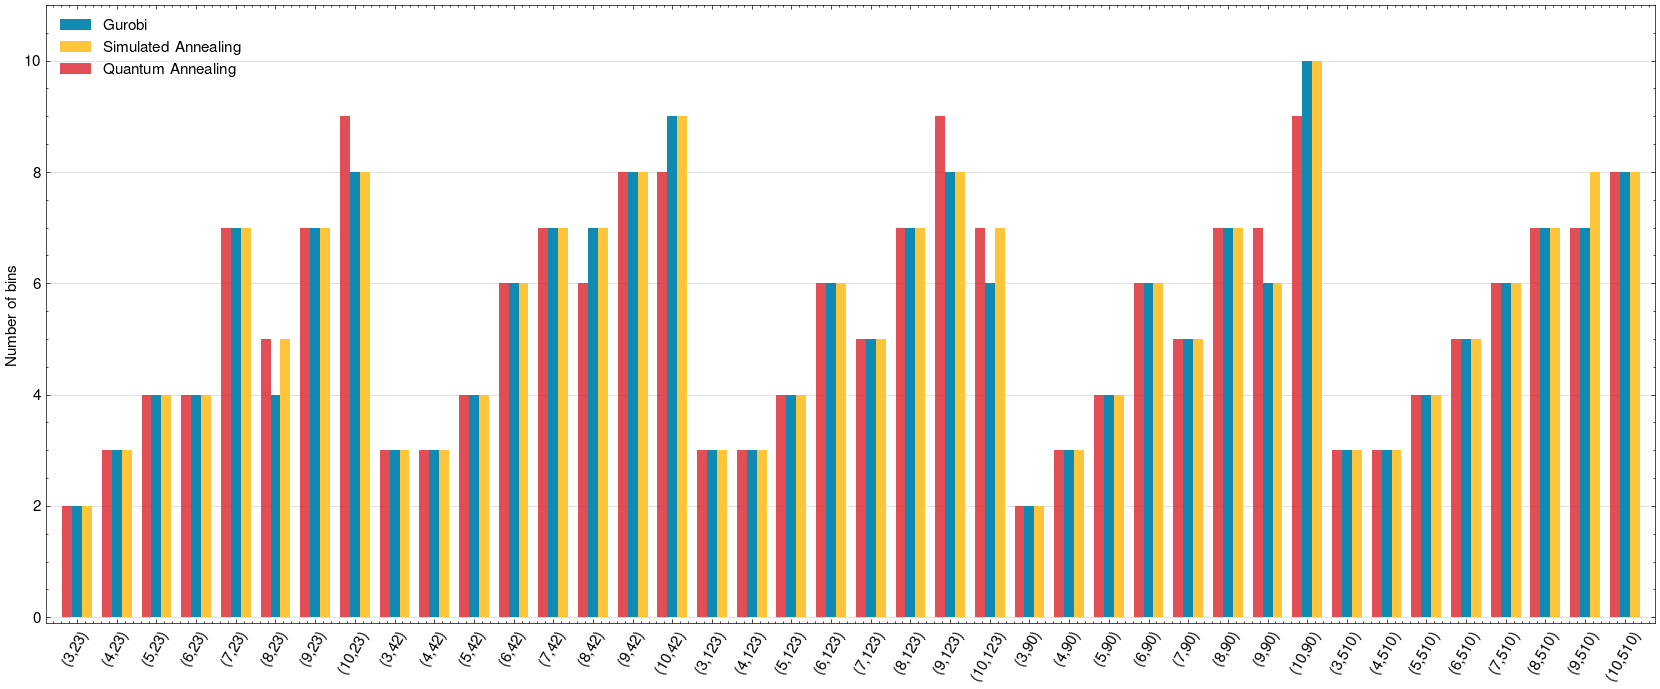

In [53]:
plot_num_bins(df_num_bins)

## Complexity plot

The following cell generate a plot illustrating the model complexity with respect to the number of items and bin capacity.

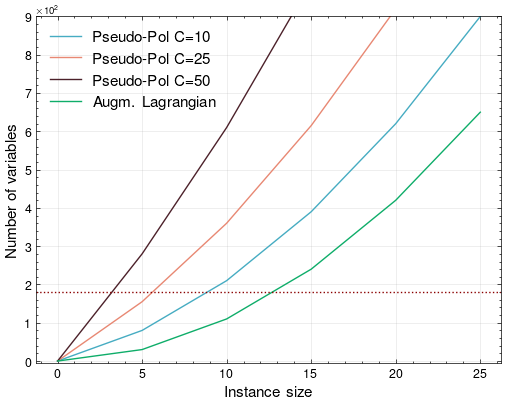

In [115]:
plot_complexity()

## Runtime

The following cells create a plot to illustrate the runtime performance of the QAL-BPP model for various problem instances. It compares the runtime results for different solvers,
including Gurobi, Simulated Annealing (SA) with Augmented Lagrangian (AL) and Quantum Annealing (QA) with Augmented Lagrangian (AL).


In [56]:
df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_QA.columns = df_mean_std_runtime_QA.columns.map('_'.join)
display(df_mean_std_runtime_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime = df_mean_std_runtime.loc[:,~df_mean_std_runtime.columns.duplicated()].reset_index()
display(df_mean_std_runtime)

<ipython-input-56-04325199534e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,427.1362,15.621034,102996.0,12620.668762
bpp_4_10,4,552.3946,99.930371,123708.0,27005.631265
bpp_5_10,5,830.9184,163.170256,140348.0,21894.696161
bpp_6_10,6,1000.1356,127.824239,134496.0,39269.900433
bpp_7_10,7,1100.3138,209.080665,153008.0,35146.529274
bpp_8_10,8,2314.5636,1729.285655,181608.0,9381.264307
bpp_9_10,9,1688.9130,219.395725,212296.0,18265.855578
bpp_10_10,10,2892.8896,786.617839,211468.0,15191.350170


<ipython-input-56-04325199534e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602
bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277
bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486
bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342
bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484
bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172
bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661
bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023


<ipython-input-56-04325199534e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602,102996.0,12620.668762,1.331339e+04,9541.950851
1,bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277,123708.0,27005.631265,2.449602e+06,502457.992174
2,bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486,140348.0,21894.696161,1.000000e+13,0.000000
3,bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342,134496.0,39269.900433,1.000000e+13,0.000000
4,bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484,153008.0,35146.529274,1.000000e+13,0.000000
5,bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172,181608.0,9381.264307,1.000000e+13,0.000000
6,bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661,212296.0,18265.855578,1.000000e+13,0.000000
7,bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023,211468.0,15191.350170,1.000000e+13,0.000000


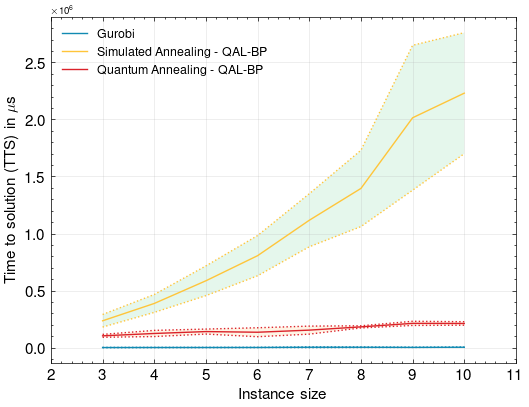

In [113]:
plot_runtime(df_mean_std_runtime)

<ipython-input-114-192280186365>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_total_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,427.1362,15.621034,103817.399689,12713.351459
bpp_4_10,4,552.3946,99.930371,125233.926590,27244.536547
bpp_5_10,5,830.9184,163.170256,142938.370178,22267.411139
bpp_6_10,6,1000.1356,127.824239,137934.949585,39138.212948
bpp_7_10,7,1100.3138,209.080665,159639.851196,36093.933121
bpp_8_10,8,2314.5636,1729.285655,193812.551697,8223.121543
bpp_9_10,9,1688.9130,219.395725,224972.048279,19226.686701
bpp_10_10,10,2892.8896,786.617839,226503.247803,14925.610769


<ipython-input-114-192280186365>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602
bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277
bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486
bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342
bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484
bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172
bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661
bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023


<ipython-input-114-192280186365>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602,103817.399689,12713.351459,1.331339e+04,9541.950851
1,bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277,125233.926590,27244.536547,2.449602e+06,502457.992174
2,bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486,142938.370178,22267.411139,1.000000e+13,0.000000
3,bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342,137934.949585,39138.212948,1.000000e+13,0.000000
4,bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484,159639.851196,36093.933121,1.000000e+13,0.000000
5,bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172,193812.551697,8223.121543,1.000000e+13,0.000000
6,bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661,224972.048279,19226.686701,1.000000e+13,0.000000
7,bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023,226503.247803,14925.610769,1.000000e+13,0.000000


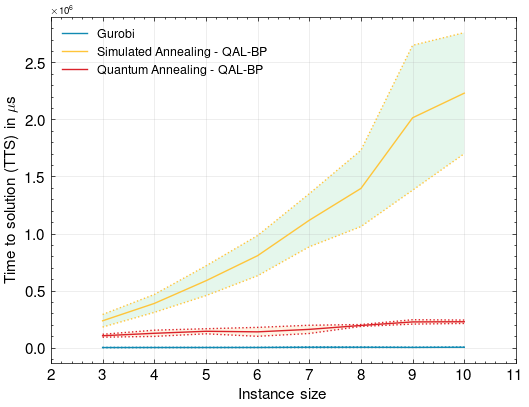

In [114]:
df_final_QA['AL_QA_runtime'] = df_final_QA['AL_QA_runtime'] + df_final_QA['AL_QA_qubo_time']

df_mean_std_runtime_total_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_total_QA.columns = df_mean_std_runtime_total_QA.columns.map('_'.join)
display(df_mean_std_runtime_total_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime_total = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_total_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime_total = df_mean_std_runtime_total.loc[:,~df_mean_std_runtime_total.columns.duplicated()].reset_index()
display(df_mean_std_runtime_total)

plot_runtime(df_mean_std_runtime_total)


Plotting the same results in log scale allows to observe also the runtime performance of the exact solver.

/content/QAL-BP/utils.py:1186: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.fill_between(df.loc[:, 'n'], upper_stock, lower_stock, alpha=0.1)


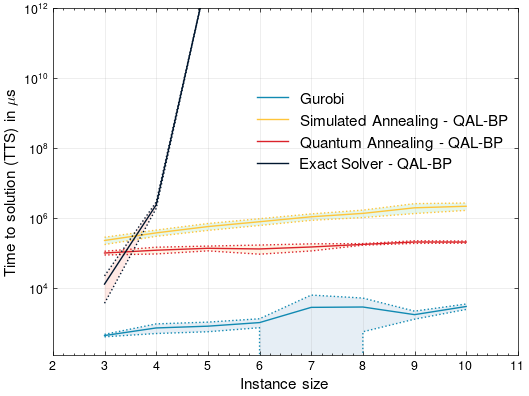

In [116]:
plot_runtime_logscale(df_mean_std_runtime)

## Minimum eigenvalues distribution

Generate a bar plot to compare the energy of the best solutions found by Simulated, Quantum, and Exact solvers.


In [134]:
df_eigen_SA = df_final_SA[['instance_name','seed','AL_SA_min_eigenvalue']]
df_eigen_QA = df_final_QA[['AL_QA_min_eigenvalue','AL_QA_cbf']]
df_eigen = pd.concat([df_eigen_SA, df_eigen_QA], axis=1)
df_eigen.head()

,instance_name,seed,AL_SA_min_eigenvalue,AL_QA_min_eigenvalue,AL_QA_cbf
0.0,bpp_3_10,23,0.1334,0.1334,0.0
1.0,bpp_4_10,23,0.0059,0.0059,0.0
2.0,bpp_5_10,23,-0.0107,-0.0107,0.0
3.0,bpp_6_10,23,0.2115,0.2115,0.0
4.0,bpp_7_10,23,0.5376,0.5376,0.0


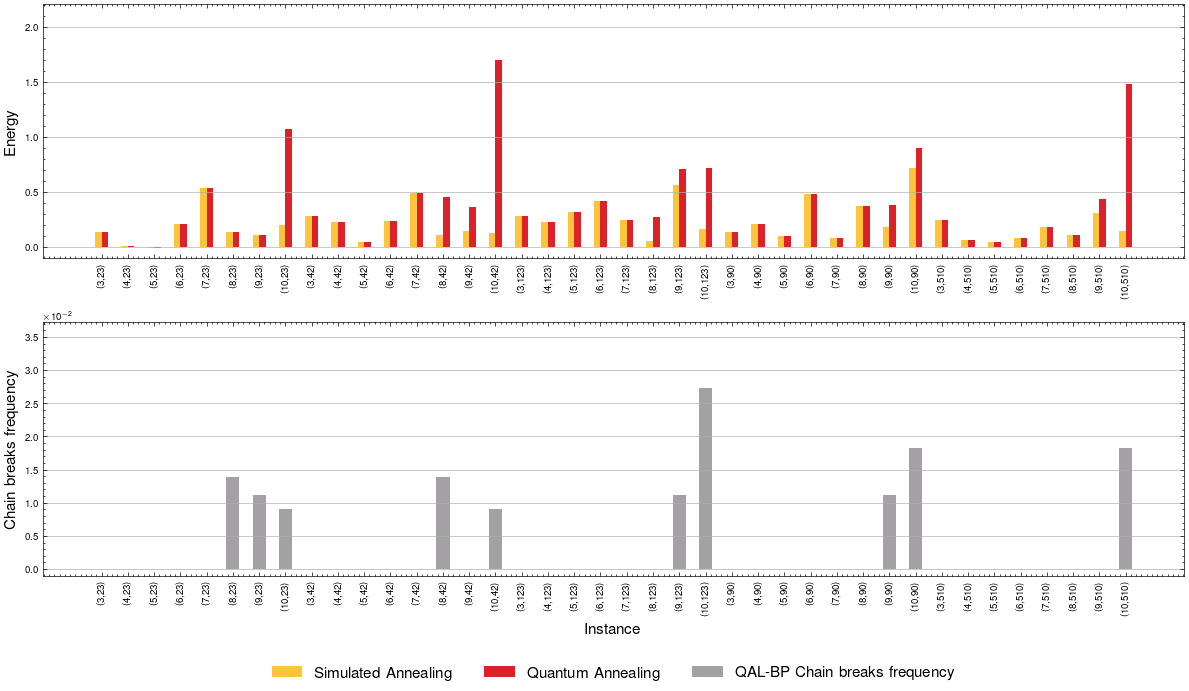

In [196]:
plot_eigenval(df_eigen)

## Feasibility density

What follows is a bar plot to visualize the probability of finding feasible solutions for different instance sizes.

In [61]:
df_feasible_density_SA = df_final_SA.groupby('instance_name', sort=False)['AL_SA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density_QA = df_final_QA.groupby('instance_name', sort=False)['AL_QA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density = pd.concat([df_feasible_density_SA, df_feasible_density_QA], axis=1)
df_feasible_density.head()

,AL_SA_feasible,AL_QA_feasible
instance_name,,
bpp_3_10,1.0,1.0
bpp_4_10,1.0,1.0
bpp_5_10,1.0,1.0
bpp_6_10,1.0,1.0
bpp_7_10,1.0,1.0


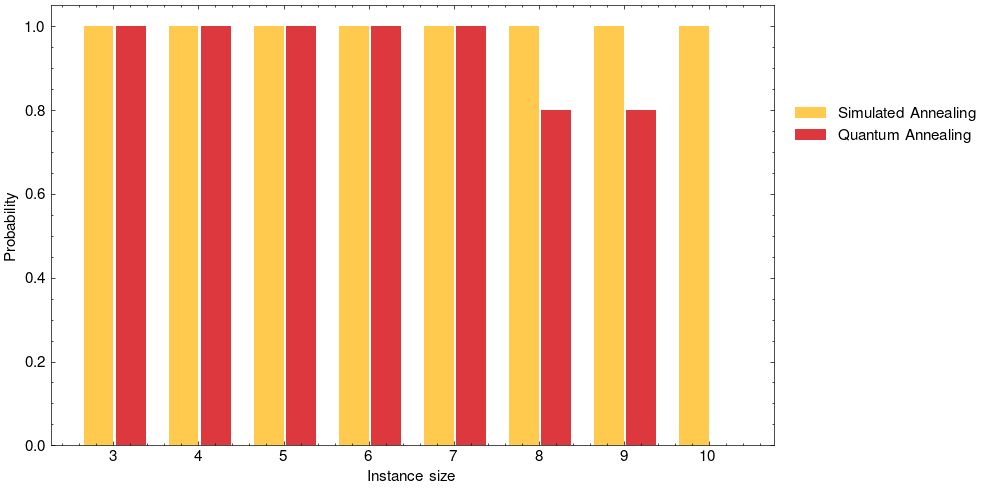

In [62]:
plot_feasibility_density(df_feasible_density)

## Chain breaks analysis

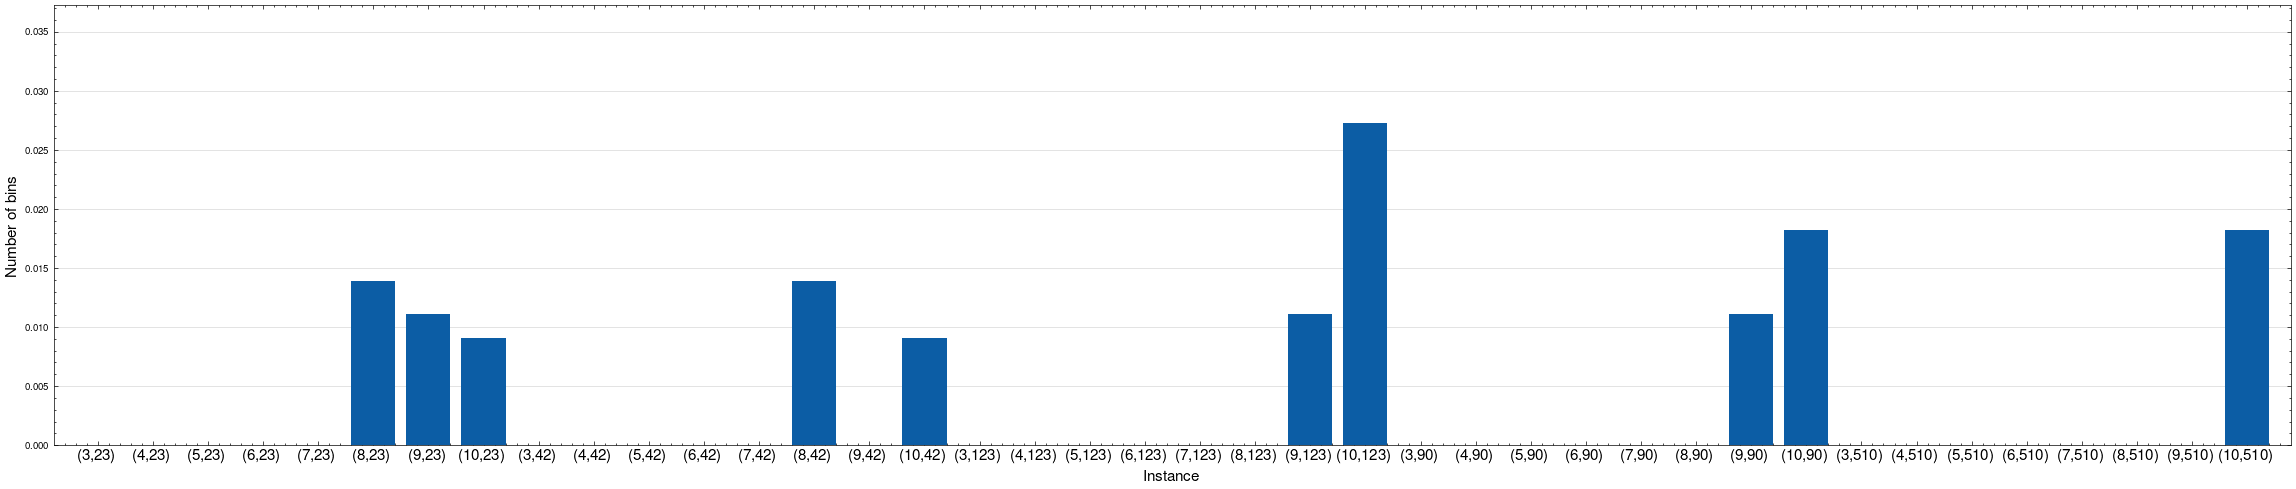

In [68]:
plot_chain_breaks(df_final_QA)

In [70]:
df_mean_std_cbf_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_cbf',
].agg(['mean', 'std'])

df_mean_std_cbf_QA.columns = df_mean_std_cbf_QA.columns.map('_'.join)
df_mean_std_cbf_QA = df_mean_std_cbf_QA.reset_index()
display(df_mean_std_cbf_QA)

,instance_name,n,AL_QA_cbf_mean,AL_QA_cbf_std
0,bpp_3_10,3,0.000000,0.000000
1,bpp_4_10,4,0.000000,0.000000
2,bpp_5_10,5,0.000000,0.000000
3,bpp_6_10,6,0.000000,0.000000
4,bpp_7_10,7,0.000000,0.000000
5,bpp_8_10,8,0.005556,0.007607
6,bpp_9_10,9,0.006667,0.006086
7,bpp_10_10,10,0.016364,0.007606


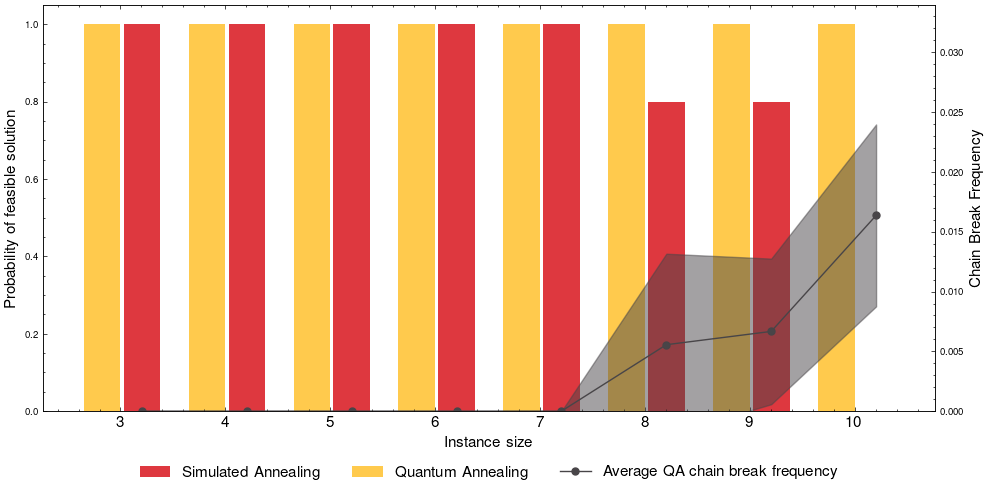

In [105]:
plot_feasibility_vs_cbf(df_feasible_density, df_mean_std_cbf_QA)

## Runtime metrics

In [129]:
df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_runtime_metrics_qpu_sampling_time',
       'AL_QA_runtime_metrics_qpu_anneal_time_per_sample',
       'AL_QA_runtime_metrics_qpu_readout_time_per_sample',
      #  'AL_QA_runtime_metrics_qpu_access_time',
      #  'AL_QA_runtime_metrics_qpu_access_overhead_time',
       'AL_QA_runtime_metrics_qpu_programming_time',
       'AL_QA_runtime_metrics_qpu_delay_time_per_sample',
      #  'AL_QA_runtime_metrics_total_post_processing_time',
       'AL_QA_runtime_metrics_post_processing_overhead_time',
       'AL_QA_qubo_time'
       ].agg(['mean', 'std'])

df_mean_std_runtime_metrics_QA.columns = df_mean_std_runtime_metrics_QA.columns.map('_'.join)
df_mean_std_runtime_metrics_QA = df_mean_std_runtime_metrics_QA.reset_index()
display(df_mean_std_runtime_metrics_QA)

<ipython-input-129-9a0bec5bfb5d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[


,instance_name,n,AL_QA_runtime_metrics_qpu_sampling_time_mean,AL_QA_runtime_metrics_qpu_sampling_time_std,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_mean,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_std,AL_QA_runtime_metrics_qpu_readout_time_per_sample_mean,AL_QA_runtime_metrics_qpu_readout_time_per_sample_std,AL_QA_runtime_metrics_qpu_programming_time_mean,AL_QA_runtime_metrics_qpu_programming_time_std,AL_QA_runtime_metrics_qpu_delay_time_per_sample_mean,AL_QA_runtime_metrics_qpu_delay_time_per_sample_std,AL_QA_runtime_metrics_post_processing_overhead_time_mean,AL_QA_runtime_metrics_post_processing_overhead_time_std,AL_QA_qubo_time_mean,AL_QA_qubo_time_std
0,bpp_3_10,3,102996.0,12620.668762,20.0,0.0,62.456,12.620669,15760.53,0.456070,20.54,0.0,691.4,771.338966,273.799896,51.515685
1,bpp_4_10,4,123708.0,27005.631265,20.0,0.0,83.168,27.005631,15760.69,0.438178,20.54,0.0,654.4,215.972915,508.642197,141.958154
2,bpp_5_10,5,140348.0,21894.696161,20.0,0.0,99.808,21.894696,15760.21,0.726636,20.54,0.0,1527.0,524.097796,863.456726,219.297637
3,bpp_6_10,6,134496.0,39269.900433,20.0,0.0,93.956,39.269900,15760.61,0.669328,20.54,0.0,1153.2,290.765713,1146.316528,347.023422
4,bpp_7_10,7,153008.0,35146.529274,20.0,0.0,112.468,35.146529,15761.81,1.003992,20.54,0.0,2435.8,1007.069362,2210.617065,591.903210
5,bpp_8_10,8,181608.0,9381.264307,20.0,0.0,141.068,9.381264,15761.65,1.425482,20.54,0.0,2667.4,741.817228,4068.183899,2061.601189
6,bpp_9_10,9,212296.0,18265.855578,20.0,0.0,171.756,18.265856,15761.89,1.245793,20.54,0.0,2065.8,406.145540,4225.349426,1106.489935
7,bpp_10_10,10,211468.0,15191.350170,20.0,0.0,170.928,15.191350,15761.97,1.469694,20.54,0.0,4094.6,1361.430975,5011.749268,2057.553169


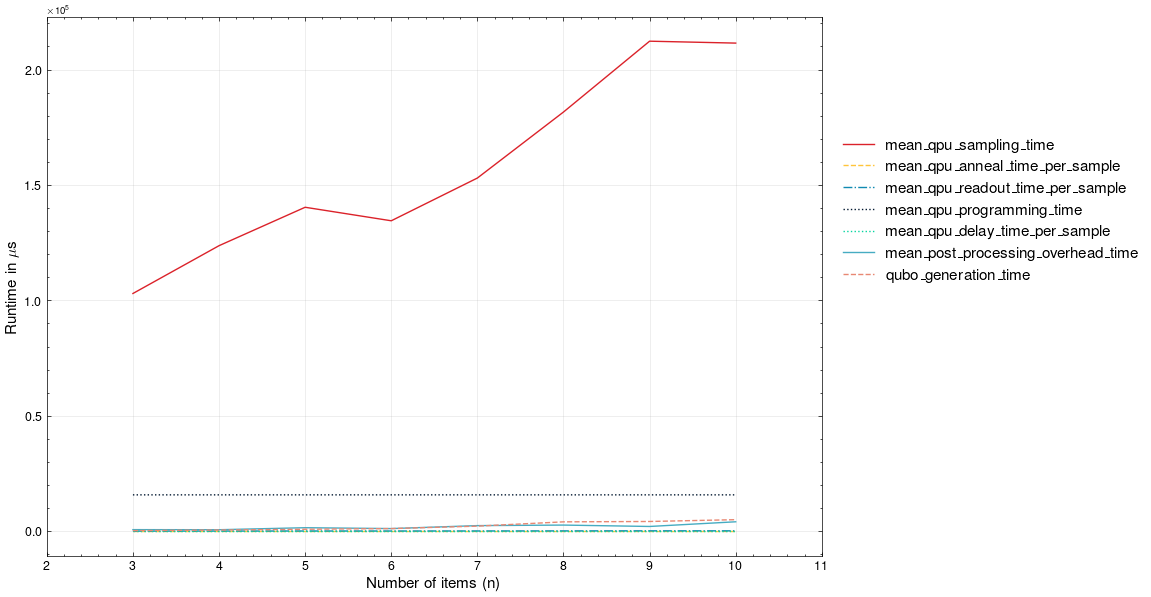

In [130]:
plot_all_runtime_metrics(df_mean_std_runtime_metrics_QA)

## Physical vs logical qubits

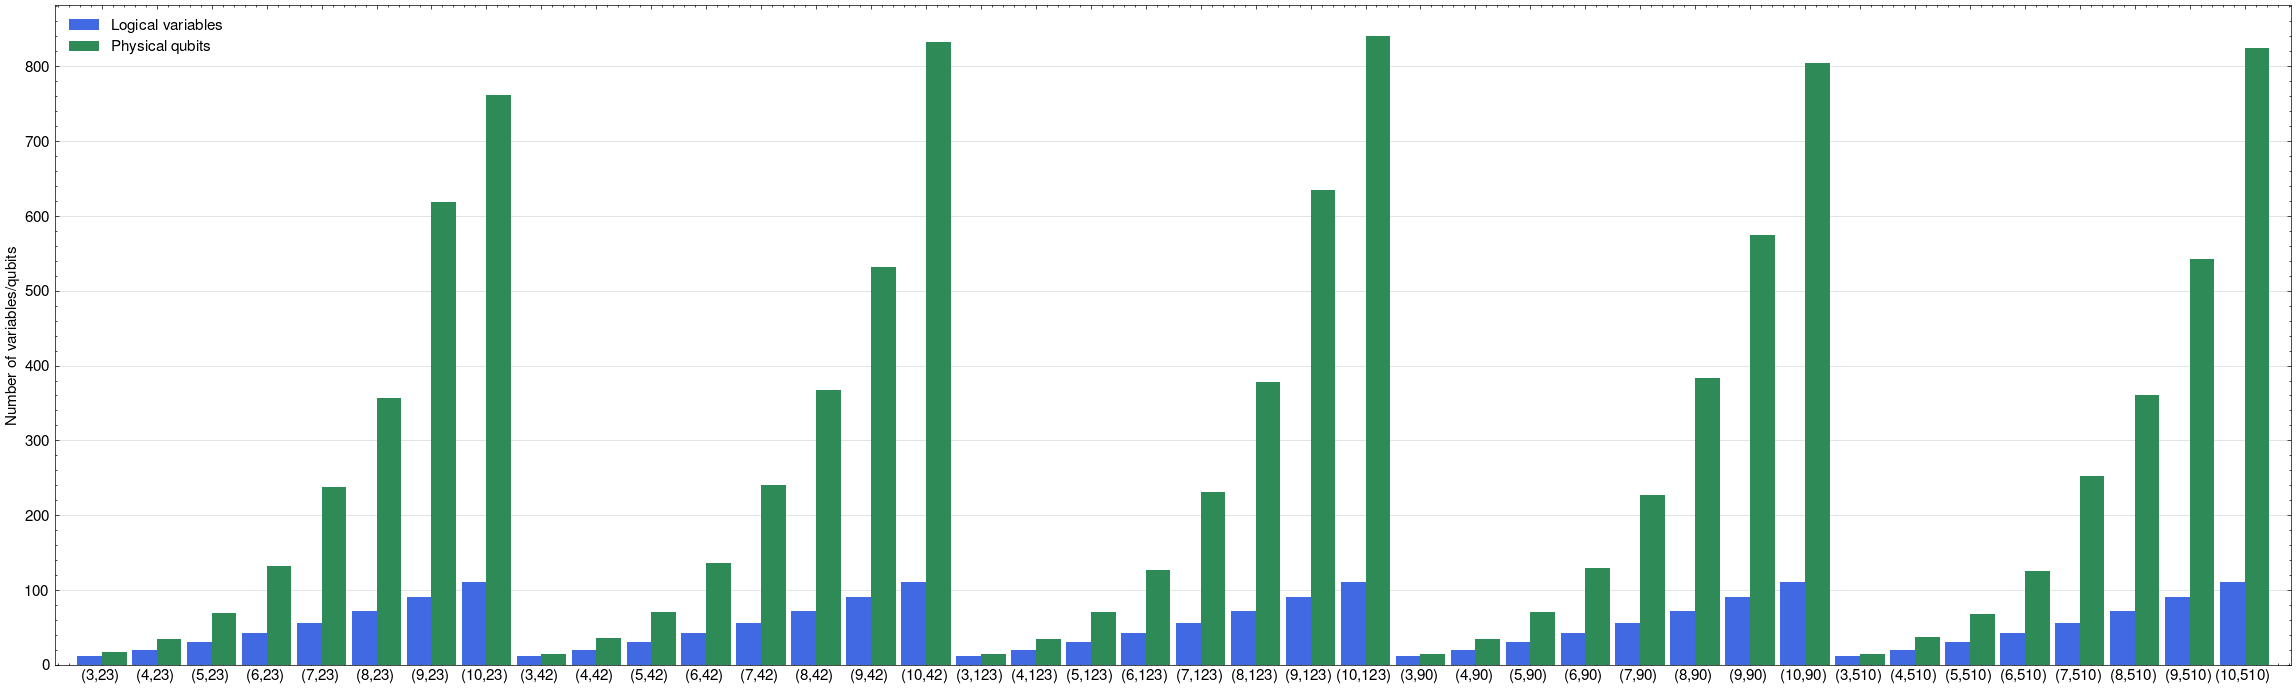

In [69]:
plot_phys_log_qubits(df_final_QA)

# Download solutions

In [ ]:
if df_feasible_density.loc['bpp_8_10']['AL_QA_feasible'] > 0:

  # shutil.move("SA_nr100.csv", "solutions/")
  shutil.move("QA_nr100.csv", "solutions/")
  shutil.move("chain_breaks_frequency.png", "solutions/")
  shutil.move("feasible_density.png", "solutions/")

  !zip -r solutions.zip solutions/

  from google.colab import files
  files.download("solutions.zip")